# Deutsch-Jozsa Algorithm
<hr></hr>

Deutsch's algorithm (named after David Deutsch) was the first demonstration of how quantum computing provides an advantage over classical computational methods [[Deutsch85](https://www.cs.princeton.edu/courses/archive/fall06/cos576/papers/deutsch85.pdf)]. The algorithm was later generalized for more than one qubit by David Deutsch and Ricahrd Jozsa [[Deutsch92](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.1992.0167)], in what is today known as the [Deutsch-Jozsa algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm).

Even though these two algorithms do not solve problems of practical importance, they are of indisputable historical importance, and laid the foundation for the development of all other quantum algorithms known today.

## 1. Deutsch's Algorithm

The formulation of the popularized version of Deutsch's algorithm was first presented by Richard Cleve, et. al. in 1997 [[Cleve97](https://arxiv.org/abs/quant-ph/9708016)], and differs from Deutsch's original proposal in that it **deterministically** provides a solution to a problem in less tries than what can be accomplished classically.

We will start by describing of how the algorithm works by casting it as a guessing game, followed by a formal definition in terms of a [quantum function evaluation](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#quantum-function-evaluation).

### 1.1 General Description

A relatively intuitive way to understand Deutsch's algorithm is by setting up the problem in the form of a game. 

Imagine you are presented with a black box with two inputs and two outputs.

<img src="images/04_01_01_black_box.png" align = "center" width="700"/>

The box is "black" because you can't see what's inside; however, you are told that, with certainty, the box corresponds to one of four possible reversible circuits:

<img src="images/04_01_02_oracles.png" align = "center" width="750"/>

1. The first circuit is simple, both inputs go straight to the output.

2. The second circuit is similar, except the bottom input is always negated.

3. In the third circuit, the bottom output gets negated _if_ the top input is 1.

4. In the fourth circuit, the bottom output gets negated _if_ the top input is 0.

There are then two types of circuits: 

$\text{I}$. Those where the top and bottom paths are independent of each other (circuits 1 and 2),

$\text{II}$. Those where the top input can "influence" the bottom output (circuits 3 and 4).

To win the game, you have to correctly guess which of these two types of circuits is inside the box ($\text{I}$ or $\text{II}.$)

A first naïve strategy is to check if there is a combination of classical $x, y \in \{0, 1\}$ input values that results in an output that is different for each type of circuit. Now, since the top output is just a direct copy of the input $|x\rangle$, it gives us no information about the circuit. We then only need to focus on what happens to the bottom output. Furthermore, given that the objective is to find if we have a box where the top path controls the bottom path (or not), the value that $y$ takes is irrelevant, so we can set it to $0$. We can then represent our black-box problem in terms of a single input $|x\rangle$ and a single output $|f(x)\rangle$:

<img src="images/04_01_03_black_box_simp.png" align = "center" width="270"/>

where we have a different $f(x)$ for each of the four possible circuits:

1. $f_1(x) = 0$. The output is always $|0\rangle,$ independent of the value of the input.

2. $f_2(x) = 1$. The output is always $|1\rangle,$ independent of the value of the input.

3. $f_3(x) = x$. The output is $|x\rangle;$ i.e., the same value as the input.

4. $f_4(x) = \bar{x}$. The output is $|\bar{x}\rangle;$ i.e., the opposite value of the input.

We can also summarize these four functions using Boolean tables:

<div style="display: flex; flex-wrap: wrap; gap: 20px;">

<div style="flex: 1;">

| $x$ | $f_1(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $0$   |

    
</div>

<div style="flex: 1;">

| $x$ | $f_2(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_3(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_4(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $0$   |
    
</div>

</div>

Since circuits 1 and 2 always generate the same output, we call them <span style="color:#a883f7">**constant**</span>. On the other hand, since circuits 3 and 4 generate both possible outputs, we call them <span style="color:#a883f7">**balanced**</span>. So our guessing game basically consists of figuring out if we have a constant or a balanced circuit.

Now, here is the culprit. Since we only get one chance at guessing which box we have, it is impossible for us to come up with a strategy to always win. If we were to always set our input to $|0\rangle$, we wouldn't be able to differentiate circuit 1 from circuit 3 because they both give an output of $|0\rangle$ (or circuit 2 from circuit 4 because they both give an output of $|1\rangle$). Similarly, if we were to always set our input to $|1\rangle$, we would never be able to tell circuit 1 and circuit 4 apart because they both give an output of $|0\rangle$ (or circuit 2 from circuit 2 because they both give an output of $|1\rangle$).

Therefore, our probability of winning using this classical strategy is of only $50 \%$.

Let's simulate this by creating a function that generates a random black box, and then we take a random guess of it being either _constant_ or _balanced_.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler

In [112]:
# Function that generates at random (with equal probability) each of the four possible circuits
def black_box():
    
    bb_val = np.random.randint(0,4) # Choose one of four possible black-box circuits
    
    qc_bb = QuantumCircuit(2, name='Black Box')
    
    match bb_val:
        case 0: 
            pass                          # Option 1: Leave circuit empty
        case 1:
            qc_bb.x(1)                    # Option 2: Add X gate to bottom qubit
        case 2:
            qc_bb.cx(1,0,ctrl_state='1')  # Option 3: Add CX gate between top and bottom qubits
        case 3:
            qc_bb.cx(1,0,ctrl_state='0')  # Option 3: Add C̅X gate between top and bottom qubits
            
    return qc_bb.to_gate()

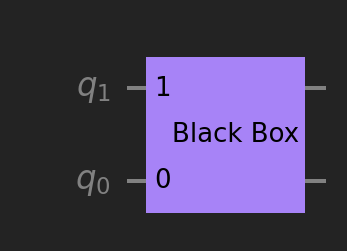

In [121]:
qc = QuantumCircuit(2)

qc.append(black_box(),[0,1])
qc.draw()

### 1.2 A more formal Explanation